In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from collections import Counter
import random
from tqdm import tqdm
import time
import pickle
from matplotlib.colors import LinearSegmentedColormap

In [3]:
shuffled = pd.read_pickle('/content/drive/MyDrive/Mag naloga/EPFL/repo_koda/MultiTSS/Data/shuffled_1000.pkl')

In [6]:
with open('/content/drive/MyDrive/Mag naloga/EPFL/repo_koda/MultiTSS/Data/shuffled_processed.pkl', 'rb') as f:
    data = pickle.load(f)
    positions, z_scores, raw_values, dataindex = data['positions'], data['z_scores'], data['raw_values'], data['dataindex']

## SHUFFLE RESULT
raw_values['raw_shuf'], raw_values['raw_control']

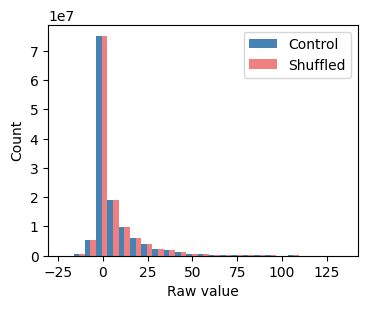

In [7]:
num_bins = 25
hist_data1, bins = np.histogram(raw_values['raw_control'].flatten(), bins=num_bins)
hist_data2, _ = np.histogram(raw_values['raw_shuf'].flatten(), bins=bins)
bar_width = (bins[1] - bins[0]) / 2

fig = plt.figure(figsize=(4, 3))
plt.bar(bins[:-1], hist_data1, width=bar_width, alpha=1, label='Control', color='steelblue')
plt.bar(bins[:-1] + bar_width, hist_data2, width=bar_width, alpha=1, label='Shuffled', color='lightcoral')

plt.xlabel('Raw value')
plt.ylabel('Count')
plt.legend()
plt.show()

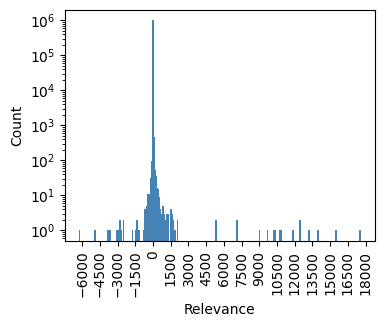

In [8]:
fig = plt.figure(figsize=(4, 3))
num_bins = 250
hist_data1, bins = np.histogram(raw_values['normalized'], bins=num_bins)
bar_width = (bins[1] - bins[0]) / 2
plt.bar(bins[:-1] + bar_width, hist_data1, width=bar_width+100, alpha=1, label='Shuffled', color='steelblue')
plt.xticks([-6000,-4500, -3000, -1500, 0, 1500, 3000, 4500, 6000, 7500, 9000, 10500, 12000, 13500, 15000, 16500, 18000], rotation=90)
plt.xlabel('Relevance')
plt.ylabel('Count')
plt.yscale('log')
plt.show()

In [9]:
scores_groups = raw_values['normalized'].reshape(-1, 5)
limit = np.percentile(np.abs(raw_values['normalized']), 90)
print('limit corresponding to 90th percentile', limit)

limit corresponding to 90th percentile 0.0006053104123566299


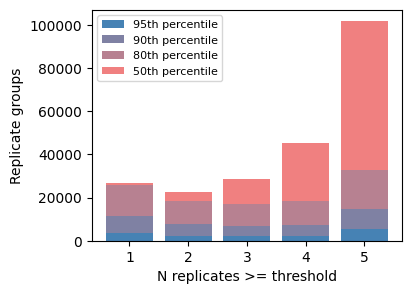

In [11]:
matrix = scores_groups
# Define thresholds
percentiles = [ 95, 90, 80, 50]
thresholds = []
for p in percentiles:
  thresholds.append(np.percentile(np.abs(raw_values['normalized']), p))

# Prepare a list to store the counts of rows meeting each threshold
threshold_counts = {t: [] for t in thresholds}

# Count the number of columns at or above each threshold for each row
for t in thresholds:
    count_per_row = np.sum(np.abs(matrix) >= t, axis=1)
    for i in range(1, 6):
        threshold_counts[t].append(np.sum(count_per_row == i))

data = [threshold_counts[t] for t in thresholds]
x = np.arange(1, 6)
bar_width = 0.8
fig, ax = plt.subplots(figsize=(4, 3))

cmap = LinearSegmentedColormap.from_list('custom_cmap', ['steelblue', 'lightcoral'], N=len(thresholds))
colors = [cmap(i / (len(thresholds) - 1)) for i in range(len(thresholds))]

# Initialize the bottom array for stacking
bottom = np.zeros(len(x))

# Plot each threshold's data as a stacked bar
for i, t in enumerate(thresholds):
    ax.bar(x, data[i], width=bar_width, color=colors[i], label=f'{percentiles[i]}th percentile', bottom=bottom)
    bottom += data[i]

ax.set_xlabel('N replicates >= threshold')
ax.set_ylabel('Replicate groups')
ax.set_xticks(x)
ax.set_xticklabels(x)
ax.legend(fontsize=8)
plt.show()

## INDEX SHIFT

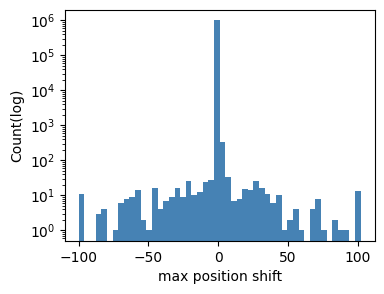

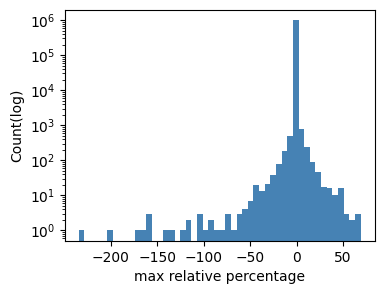

In [13]:
bins = np.histogram_bin_edges([x for x in range(-300, 200)], bins='auto')

fig = plt.figure(figsize=(4, 3))
plt.hist(positions['index_difference'].flatten(), log=True, bins=50, color='steelblue')
plt.xlabel('max position shift')
plt.ylabel('Count(log)')
plt.show()


fig = plt.figure(figsize=(4, 3))
plt.hist(positions['percentage_difference'].flatten(), log=True, bins=50, color='steelblue')
plt.xlabel('max relative percentage')
plt.subplots_adjust(hspace=0.25)
plt.ylabel('Count(log)')
plt.show()

## 2000 UPSTREAM

In [15]:
# for each of 2000 upstream position look at effect on prediction
def sort_by_changed_input(shuffled_input, z_scores, dataindex):
  position_data = {x:[] for x in range(0, 2000)}

  for i, shi in tqdm(enumerate(dataindex), total=z_scores.shape[0]):  # row i corresponds to index shi
    if i >= z_scores.shape[0]: break
    datarow = shuffled.loc[shi]
    for position in range(datarow.shuffle_position, datarow.shuffle_position+datarow.motif_size):
      position_data[position].append(z_scores[i])
  return position_data

In [16]:
position_data = sort_by_changed_input(shuffled, raw_values['normalized'], dataindex)

100%|██████████| 1000000/1000000 [03:32<00:00, 4699.50it/s]


In [17]:
max_values = []
avg_values = []
std_values = []
# Iterate over the dictionary
for key, matrix in tqdm(position_data.items()):
  filtered_values = np.array(matrix)
  max_values.append(np.max(filtered_values))
  avg_values.append(np.mean(filtered_values))
  std_values.append(np.std(filtered_values))

100%|██████████| 2000/2000 [00:07<00:00, 279.11it/s]


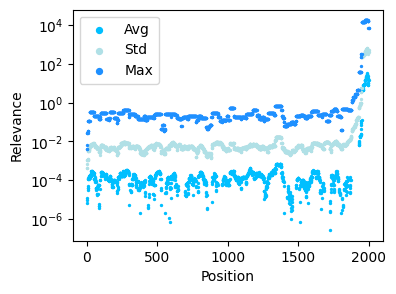

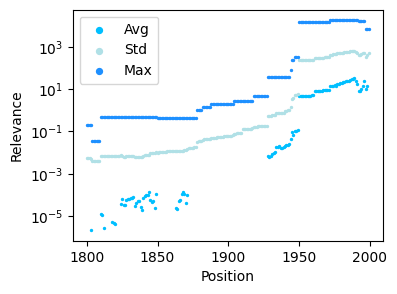

In [19]:
plt.figure(figsize=(4, 3))
plt.scatter(range(len(avg_values)), avg_values, color='deepskyblue', label='Avg', s=2)
plt.scatter(range(len(std_values)), std_values, color='powderblue', label='Std', s=2)
plt.scatter(range(len(std_values)), max_values, color='dodgerblue', label='Max', s=2)

plt.xlabel('Position')
plt.ylabel('Relevance')
plt.yscale('log')
plt.legend(markerscale=3)
plt.show()


plt.figure(figsize=(4, 3))
plt.scatter(range(1800, 2000), avg_values[1800:], color='deepskyblue', label='Avg', s=2)
plt.scatter(range(1800, 2000), std_values[1800:], color='powderblue', label='Std', s=2)
plt.scatter(range(1800, 2000), max_values[1800:], color='dodgerblue', label='Max', s=2)

plt.xlabel('Position')
plt.ylabel('Relevance')
plt.yscale('log')
plt.legend(markerscale=3)
plt.show()